# 🤖 LLM: Многомерное прогнозирование с большими языковыми моделями

Этот блокнот реализует многомерное прогнозирование финансовых временных рядов с использованием **больших языковых моделей (LLM)** - инновационный подход к анализу временных рядов через естественный язык.

## 🎯 Основные особенности

- **Многомерные данные**: используем данные из папки `/data/multivariate_series/`
- **Поэтапные признаки**: различные этапы добавления фичей согласно progressive feature analysis
- **Walk-forward прогнозирование**: честное тестирование с расширяющимся окном
- **Горизонт прогноза**: 10 точек
- **Размер теста**: 11 точек
- **Множественные LLM**: GPT-4o-mini, DeepSeek, Claude, LLaMA, Gemini и другие
- **Метрики**: RMSE, MAPE, DA (Directional Accuracy)

## 📊 Структура этапов признаков

1. **Этап 1**: Только цены закрытия (close)
2. **Этап 2**: + Аномалии (anomaly)
3. **Этап 3**: + Новостные настроения (weighted_score_with_decay)
4. **Этап 4**: + Базовые OHLCV признаки
5. **Этап 5**: + Технические индикаторы
6. **Этап 6**: + Статистические признаки (TSFresh)

## 🤖 LLM модели для тестирования

### 🌐 Через OpenRouter API:
- **GPT-4o-mini**: компактная версия GPT-4o от OpenAI
- **LLaMA-4**: модель от Meta
- **Claude-Haiku**: быстрая модель от Anthropic
- **DeepSeek-R1**: рассуждающая модель от DeepSeek
- **Gemini-2.5-Pro**: новейшая модель от Google
- **Qwen-QwQ**: модель от Alibaba с рассуждением

### 🔗 Прямые API:
- **DeepSeek-Chat**: специализированная модель от DeepSeek
- **GigaChat**: российская LLM от Сбербанка

## 🔬 Методология
- **Zero-shot прогнозирование**: без дообучения, использование естественного языка
- **Patch-based подход**: разбиение временного ряда на патчи с статистическими подсказками
- **Walk-forward валидация**: строгая проверка на будущих данных с расширяющимся окном
- **Robust parsing**: извлечение числовых значений из ответов LLM
- **Anomaly handling**: обработка галлюцинаций и повторные попытки
- **Прогноз**: 10 точек вперед на каждом шаге


In [1]:
# Установка и импорты
import warnings
warnings.filterwarnings('ignore')

import os
import time
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import statistics
import re
from typing import List, Dict, Tuple, Optional
from datetime import datetime
import logging

# Проверка и установка необходимых библиотек
try:
    from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
    from langchain.schema import HumanMessage, SystemMessage
    from langchain_gigachat import GigaChat
    print("✅ Основные библиотеки доступны")
except ImportError:
    print("📦 Устанавливаем недостающие библиотеки...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", 
                          "requests", "langchain", "langchain-gigachat", 
                          "gigachat", "openai", "--quiet"])
    from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
    from langchain.schema import HumanMessage, SystemMessage
    from langchain_gigachat import GigaChat
    print("✅ Библиотеки установлены и импортированы")

# Настройка визуализации
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 12

# Настройка логирования
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Установим читаемый формат для вывода чисел
pd.options.display.float_format = '{:.4f}'.format

print("📚 Библиотеки загружены успешно!")
print("🤖 Готов к работе с LLM моделями!")

✅ Основные библиотеки доступны
📚 Библиотеки загружены успешно!
🤖 Готов к работе с LLM моделями!


In [24]:
# Конфигурация (точно как в других multivariate блокнотах)
DATA_PATH = "../../data/multivariate_series/"
OUTPUT_PATH = "results/multivariate_llm/"
FORECAST_HORIZON = 10  # Прогнозируем на 10 точек
TEST_SIZE = 11  # Размер тестового набора
PATCH_SIZE = 30  # Размер патча для LLM анализа

# Создаем папку для результатов
Path(OUTPUT_PATH).mkdir(parents=True, exist_ok=True)

# Список тикеров (точно как в других multivariate блокнотах)
TICKERS = ['AFLT', 'LKOH', 'MOEX', 'NVTK', 'PIKK', 'SBER', 'VKCO', 'VTBR', 'X5', 'YDEX']

# Названия этапов для отображения (как в LLM_Progressive_Clean - 8 этапов)
STAGE_NAMES = {
    1: "Базовая цена (close)",
    2: "Цена + аномалии", 
    3: "Цена + аномалии + новости",
    4: "Всё выше + заголовки новостей",
    5: "Всё выше + OHLCV",
    6: "Всё выше + технические индикаторы",
    7: "Всё выше + статистические признаки TSFresh",
    8: "Всё из этапа 7 + визуализация графиков"
}

# API ключи (замените на свои!)
API_KEYS = {
    'openrouter': "",
    'deepseek': "",
    'gigachat': ""
}

print(f"Настройки:")
print(f"- Путь к данным: {DATA_PATH}")
print(f"- Горизонт прогноза: {FORECAST_HORIZON}")
print(f"- Размер тест. данных: {TEST_SIZE}")
print(f"- Размер патча: {PATCH_SIZE}")
print(f"- Количество тикеров: {len(TICKERS)}")
print(f"- Папка результатов: {OUTPUT_PATH}")

Настройки:
- Путь к данным: ../../data/multivariate_series/
- Горизонт прогноза: 10
- Размер тест. данных: 11
- Размер патча: 30
- Количество тикеров: 10
- Папка результатов: results/multivariate_llm/


In [25]:
# Функции для подготовки признаков по этапам (как в LLM_Progressive_Clean)
import base64
import io

# Predefined feature groups (как в LLM_Progressive_Clean)
_BASE = ['close', 'anomaly', 'weighted_score_with_decay']
_OHLV = ['open', 'high', 'low', 'volume']
_TECH = [
    'return', 'SMA_14', 'SMA_50', 'EMA_14', 'EMA_50', 'RSI_14',
    'MACD', 'MACD_signal', 'BB_hband', 'BB_lband', 'ATR_14', 'OBV', 'VWAP'
]

_FEATURE_MAP = {
    1: ['close'],
    2: ['close', 'anomaly'],
    3: ['close', 'anomaly', 'weighted_score_with_decay'],
    4: ['close', 'anomaly', 'weighted_score_with_decay', 'daily_headlines'],
    5: _BASE + _OHLV,
    6: _BASE + _OHLV + _TECH,
    7: _BASE + _OHLV + _TECH + ['value__'],  # TSFresh признаки
    8: _BASE + _OHLV + _TECH + ['value__'],  # То же что 7 + визуализация
}

def prepare_features_for_stage(df, stage):
    """
    Возвращает список колонок для определенного этапа (как в LLM_Progressive_Clean)
    """
    if stage not in _FEATURE_MAP:
        raise ValueError(f"Unsupported stage: {stage}")
    feats = _FEATURE_MAP[7] if stage == 8 else _FEATURE_MAP[stage]
    # Расширяем wildcard 'value__' для tsfresh
    return [col for col in df.columns
            if col in feats or any(feat == 'value__' and 'value__' in col for feat in feats)]

def create_chart_image(window_data, ticker):
    """
    Создает график цены + SMA(14/50) + RSI(14) и возвращает base64-encoded PNG
    """
    try:
        fig, (ax_price, ax_rsi) = plt.subplots(2, 1, figsize=(12, 8))

        # График цены + SMA с аннотациями
        ax_price.plot(
            window_data.index,
            window_data['close'],
            color='blue',
            linewidth=2,
            marker='o',
            label='Close'
        )
        for sma, color in (('SMA_14', 'red'), ('SMA_50', 'green')):
            if sma in window_data.columns:
                ax_price.plot(
                    window_data.index,
                    window_data[sma],
                    color=color,
                    linestyle='--',
                    linewidth=1.5,
                    alpha=0.7,
                    label=sma
                )

        # Аннотируем каждую цену закрытия
        for x, y in zip(window_data.index, window_data['close']):
            ax_price.annotate(
                f"{y:.2f}",
                xy=(x, y),
                xytext=(0, -10),
                textcoords="offset points",
                ha='center',
                fontsize=8,
                color='black'
            )

        ax_price.set_title(f"{ticker} – Window Price", fontsize=14, fontweight='bold')
        ax_price.set_ylabel('Price')
        ax_price.legend()
        ax_price.grid(alpha=0.3)

        # График RSI
        if 'RSI_14' in window_data.columns:
            ax_rsi.plot(
                window_data.index,
                window_data['RSI_14'],
                color='purple',
                linewidth=2,
                label='RSI (14)'
            )
            ax_rsi.axhline(70, color='red', linestyle='--', alpha=0.7, label='Overbought')
            ax_rsi.axhline(30, color='green', linestyle='--', alpha=0.7, label='Oversold')
            ax_rsi.set_title('RSI (14)', fontsize=12)
            ax_rsi.set_ylabel('RSI')
            ax_rsi.set_ylim(0, 100)
            ax_rsi.legend()
            ax_rsi.grid(alpha=0.3)
        else:
            ax_rsi.remove()

        plt.tight_layout()

        # Кодируем в Base64
        buffer = io.BytesIO()
        plt.savefig(buffer, format='png', dpi=100, bbox_inches='tight')
        buffer.seek(0)
        img_b64 = base64.b64encode(buffer.read()).decode('utf-8')
        plt.close(fig)
        return img_b64

    except Exception as e:
        logger.error(f"Ошибка создания графика для {ticker}: {e}")
        return None

print("✅ Функции подготовки признаков и визуализации созданы")

✅ Функции подготовки признаков и визуализации созданы


In [45]:
# Вспомогательные функции для LLM работы
def calculate_directional_accuracy(actual: np.ndarray, predicted: np.ndarray) -> float:
    """Вычисляет точность направления (DA)"""
    if len(actual) < 2 or len(predicted) < 2:
        return 0.0
    
    actual_direction = np.diff(actual) > 0
    predicted_direction = np.diff(predicted) > 0
    
    return np.mean(actual_direction == predicted_direction) * 100

def parse_llm_response(response_text: str) -> float:
    """Извлекает числовое значение из ответа LLM"""
    try:
        # Ищем первое число в ответе
        match = re.search(r"[-+]?\d*\.?\d+", str(response_text).strip())
        return float(match.group(0)) if match else np.nan
    except (ValueError, AttributeError):
        return np.nan

def load_ticker_data(ticker: str) -> Optional[pd.DataFrame]:
    """Загружает данные для тикера"""
    file_path = f"{DATA_PATH}{ticker}_multivariate.csv"
    
    if not os.path.exists(file_path):
        print(f"⚠️ Файл не найден: {file_path}")
        return None
    
    try:
        df = pd.read_csv(file_path)
        
        # Проверяем наличие timestamp колонки
        if 'timestamp' in df.columns:
            df['timestamp'] = pd.to_datetime(df['timestamp'])
            df = df.set_index('timestamp')
        
        # Сортируем по времени
        df = df.sort_index()
        
        # Проверяем наличие основных колонок
        required_cols = ['close']
        if not all(col in df.columns for col in required_cols):
            print(f"⚠️ Отсутствуют необходимые колонки в {ticker}")
            return None
        
        print(f"✅ Загружен {ticker}: {len(df)} точек, {len(df.columns)} признаков")
        return df
        
    except Exception as e:
        print(f"❌ Ошибка загрузки {ticker}: {e}")
        return None

# Функция создания патчей как в LLM_Progressive_Clean
def make_patch_messages(window_data, stage, ticker="", patch_size=5):
    """Создает детальные патчи для LLM промптов (как в LLM_Progressive_Clean)"""
    msgs = []
    features = prepare_features_for_stage(window_data, stage)
    available_features = [f for f in features if f in window_data.columns]
    
    n_patches = max(1, len(window_data) // patch_size)
    actual_patch_size = len(window_data) // n_patches
    
    for i in range(n_patches):
        start_idx = i * actual_patch_size
        end_idx = min((i + 1) * actual_patch_size, len(window_data))
        patch_data = window_data.iloc[start_idx:end_idx]
        
        characteristics = []
        
        # Всегда добавляем цены
        if 'close' in available_features:
            prices = [f"{val:.2f}" for val in patch_data['close'].values]
            characteristics.append(f"Prices: {', '.join(prices)}")
        
        if stage >= 2 and 'anomaly' in available_features:
            anomalies = [str(int(val)) if not pd.isna(val) else "0" for val in patch_data['anomaly'].values]
            characteristics.append(f"Anomaly (0-no, 1-yes): {', '.join(anomalies)}")
        
        if stage >= 3 and 'weighted_score_with_decay' in available_features:
            scores = [f"{val*100:.0f}" if not pd.isna(val) else "0" for val in patch_data['weighted_score_with_decay'].values]
            characteristics.append(f"News sentiment (-100 to +100): {', '.join(scores)}")
        
        if stage >= 4 and 'daily_headlines' in available_features:
            headlines = patch_data['daily_headlines'].dropna()
            if len(headlines) > 0:
                last_headline = str(headlines.iloc[-1])[:100]
                characteristics.append(f"Latest news: {last_headline}")
        
        if stage >= 5:
            if 'open' in available_features:
                opens = [f"{val:.2f}" for val in patch_data['open'].values]
                characteristics.append(f"Open prices: {', '.join(opens)}")
            
            if 'high' in available_features:
                highs = [f"{val:.2f}" for val in patch_data['high'].values]
                characteristics.append(f"High prices: {', '.join(highs)}")
            
            if 'low' in available_features:
                lows = [f"{val:.2f}" for val in patch_data['low'].values]
                characteristics.append(f"Low prices: {', '.join(lows)}")
            
            if 'volume' in available_features:
                volumes = [f"{val:.0f}" if not pd.isna(val) else "0" for val in patch_data['volume'].values]
                characteristics.append(f"Volumes: {', '.join(volumes)}")
        
        if stage >= 6:
            if 'EMA_14' in available_features:
                ema_vals = [f"{val:.2f}" if not pd.isna(val) else "0" for val in patch_data['EMA_14']]
                characteristics.append(f"EMA(14): {', '.join(ema_vals)}")
        
            if 'RSI_14' in available_features:
                rsi_vals = [f"{val:.1f}" if not pd.isna(val) else "50" for val in patch_data['RSI_14'].values]
                characteristics.append(f"RSI: {', '.join(rsi_vals)}")
            
            if 'MACD' in available_features:
                macd_vals = [f"{val:.3f}" if not pd.isna(val) else "0" for val in patch_data['MACD'].values]
                characteristics.append(f"MACD: {', '.join(macd_vals)}")
            
            if 'return' in available_features:
                returns = [f"{val*100:.1f}%" if not pd.isna(val) else "0%" for val in patch_data['return'].values]
                characteristics.append(f"Returns: {', '.join(returns)}")

            if 'ATR_14' in available_features:
                atr_vals = [f"{val:.2f}" if not pd.isna(val) else "0" for val in patch_data['ATR_14']]
                characteristics.append(f"ATR(14): {', '.join(atr_vals)}")
    
            if 'VWAP' in available_features:
                vwap_vals = [f"{val:.2f}" if not pd.isna(val) else "0" for val in patch_data['VWAP']]
                characteristics.append(f"VWAP: {', '.join(vwap_vals)}")

        if stage >= 7:
            # Этап 7+: добавляем статистические признаки (выборочно)
            tsfresh_stats = [
                'value__mean',
                'value__maximum',
                'value__minimum',
                'value__standard_deviation',
                'value__partial_autocorrelation__lag_3',
                'value__autocorrelation__lag_5',
                'value__longest_strike_above_mean'
            ]
            for feat in tsfresh_stats:
                if feat in available_features:
                    vals = [f"{v:.2f}" if not pd.isna(v) else "0" for v in patch_data[feat]]
                    characteristics.append(f"{feat}: {', '.join(vals)}")
        
        content = f"Патч {i+1}: " + " | ".join(characteristics)
        msgs.append({"role": "system", "content": content})
    
    # Добавляем график для 8 этапа (если поддерживается vision)
    if stage == 8:
        image_base64 = create_chart_image(window_data, ticker)
        if image_base64:
            msgs.append({
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": (
                            "You are a seasoned financial analyst. "
                            "Study the attached price chart for the ticker, which shows closing prices, SMA(14/50), and RSI(14). "
                            "Determine the current trend, momentum levels, and any support or resistance. "
                            "Then predict the next closing price. "
                            "Return only the numeric value — no explanation or extra text."
                        )
                    },
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/png;base64,{image_base64}"
                        }
                    }
                ]
            })
    
    return msgs


def convert_to_langchain_messages(raw_msgs):
    """
    Преобразует список словарей вида {'role': 'system'|'user', 'content': ...}
    в список LangChain-сообщений.
    """
    lc_msgs = []
    for m in raw_msgs:
        role = m.get("role")
        content = m.get("content")
        
        # Если контент — это список блоков (stage 8 с картинкой)
        if isinstance(content, list):
            parts = []
            for block in content:
                if block.get("type") == "text":
                    parts.append(block["text"])
                elif block.get("type") == "image_url":
                    # Вставляем просто URL — GigaChat подхватит вложение
                    parts.append(block["image_url"]["url"])
            text = "\n\n".join(parts)
        
        # Если контент — простая строка
        else:
            text = content
        
        # Конвертация по роли
        if role == "system":
            lc_msgs.append(SystemMessage(content=text))
        elif role == "user":
            lc_msgs.append(HumanMessage(content=text))
        else:
            # при необходимости можно добавить другие роли
            lc_msgs.append(HumanMessage(content=text))
    
    return lc_msgs


print("✅ Вспомогательные функции для LLM созданы")

✅ Вспомогательные функции для LLM созданы


In [70]:
# Классы LLM предикторов для разных API (адаптированы из LLM_Progressive_Clean)
import uuid

class OpenRouterPredictor:
    """LLM предиктор через OpenRouter API (как в LLM_Progressive_Clean)"""
    
    def __init__(self, api_key, model_name, max_retries=2, drop_threshold=0.15):
        self.api_key = api_key
        self.model_name = model_name
        self.api_url = "https://openrouter.ai/api/v1/chat/completions"
        self.headers = {
            "Authorization": f"Bearer {api_key}",
            "Content-Type": "application/json",
            "HTTP-Referer": "https://github.com/",
            "X-Title": "Financial Time Series Forecasting"
        }
        self.max_retries = max_retries
        self.drop_threshold = drop_threshold
    
    def predict(self, window_data, stage, ticker="", patch_size=5):
        """Прогноз следующего значения на основе временного окна"""
        prev_price = window_data['close'].iloc[-1]
        
        for attempt in range(1, self.max_retries + 1):
            try:
                # Формируем сообщения
                msgs = make_patch_messages(window_data, stage, ticker, patch_size)
                
                # Добавляем system prompt
                msgs.insert(0, {
                    "role": "system",
                    "content": (
                        "You are an expert financial forecaster. "
                        "Given the input time series data, predict the next closing price and return only the numeric value—no explanations or additional text."
                    )
                })
                
                # Финальный промпт
                if stage == 8:
                    # Для этапа с картинками уже добавлен в make_patch_messages
                    pass
                else:
                    msgs.append({
                        "role": "user",
                        "content": (
                            "Based on the provided financial metrics, predict the next closing price. "
                            "Return only the numeric value with no explanation or extra text."
                        )
                    })
                
                # Отправляем запрос
                response = requests.post(
                    self.api_url,
                    headers=self.headers,
                    json={
                        "model": self.model_name,
                        "messages": msgs,
                        "max_tokens": 20,
                        "temperature": 0.1
                    },
                    timeout=30
                )
                response.raise_for_status()
                
                # Парсим ответ
                content = response.json()["choices"][0]["message"]["content"]
                pred = parse_llm_response(content)
                
                if np.isnan(pred):
                    print(f"    Попытка {attempt}: не удалось извлечь число из '{content}'")
                    if attempt >= self.max_retries:
                        return prev_price
                    time.sleep(1)
                    continue
                
                # Проверка на аномальные значения
                if pred < prev_price * (1 - self.drop_threshold) or pred > prev_price * (1 + self.drop_threshold):
                    print(f"    Попытка {attempt}: аномальный прогноз {pred:.2f} (prev={prev_price:.2f})")
                    if attempt < self.max_retries:
                        time.sleep(1)
                        continue
                    else:
                        # Ограничиваем значение
                        return np.clip(pred, 
                                     prev_price * (1 - self.drop_threshold),
                                     prev_price * (1 + self.drop_threshold))
                
                return pred
                
            except Exception as e:
                print(f"    Ошибка попытки {attempt}: {e}")
                if attempt >= self.max_retries:
                    return prev_price
                time.sleep(1)
        
        return prev_price

class DeepSeekPredictor:
    """Предиктор для DeepSeek API"""
    
    def __init__(self, api_key, model_name="deepseek-chat", max_retries=2, drop_threshold=0.15):
        self.api_key = api_key
        self.model_name = model_name
        self.api_url = "https://api.deepseek.com/v1/chat/completions"
        self.headers = {
            "Authorization": f"Bearer {api_key}",
            "Content-Type": "application/json"
        }
        self.max_retries = max_retries
        self.drop_threshold = drop_threshold
    
    def predict(self, window_data, stage, ticker="", patch_size=5):
        """Прогноз следующего значения на основе временного окна"""
        prev_price = window_data['close'].iloc[-1]
        
        for attempt in range(1, self.max_retries + 1):
            try:
                msgs = make_patch_messages(window_data, stage, ticker, patch_size)
                
                msgs.insert(0, {
                    "role": "system",
                    "content": (
                        "You are an expert financial forecaster. "
                        "Given the input time series data, predict the next closing price and return only the numeric value—no explanations or additional text."
                    )
                })
                
                msgs.append({
                    "role": "user",
                    "content": (
                        "Based on the provided financial metrics, predict the next closing price. "
                        "Return only the numeric value with no explanation or extra text."
                    )
                })
                
                response = requests.post(
                    self.api_url,
                    headers=self.headers,
                    json={
                        "model": self.model_name,
                        "messages": msgs,
                        "max_tokens": 20,
                        "temperature": 0.1
                    },
                    timeout=30
                )
                response.raise_for_status()
                
                content = response.json()["choices"][0]["message"]["content"]
                pred = parse_llm_response(content)
                
                if np.isnan(pred):
                    print(f"    Попытка {attempt}: не удалось извлечь число из '{content}'")
                    if attempt >= self.max_retries:
                        return prev_price
                    time.sleep(1)
                    continue
                
                # Проверка на аномальные значения
                if pred < prev_price * (1 - self.drop_threshold) or pred > prev_price * (1 + self.drop_threshold):
                    print(f"    Попытка {attempt}: аномальный прогноз {pred:.2f} (prev={prev_price:.2f})")
                    if attempt < self.max_retries:
                        time.sleep(1)
                        continue
                    else:
                        return np.clip(pred, 
                                     prev_price * (1 - self.drop_threshold),
                                     prev_price * (1 + self.drop_threshold))
                
                return pred
                
            except Exception as e:
                print(f"    Ошибка попытки {attempt}: {e}")
                if attempt >= self.max_retries:
                    return prev_price
                time.sleep(1)
        
        return prev_price

class GigaChatPredictor:
    """Предиктор на базе GigaChat от Сбербанка"""
    
    def __init__(self, api_key, model_name="GigaChat", max_retries=2, drop_threshold=0.15):
        self.api_key = api_key
        self.client = None
        self.max_retries = max_retries
        self.drop_threshold = drop_threshold
        self._init_client()
    
    def _init_client(self):
        """Инициализация клиента GigaChat"""
        try:
            self.client = GigaChat(
                credentials=self.api_key,
                verify_ssl_certs=False,
                model="GigaChat"
            )
            logger.info("GigaChat client initialized successfully")
        except ImportError:
            logger.error("GigaChat libraries not available. Please install langchain-gigachat")
            self.client = None
        except Exception as e:
            logger.error(f"Failed to initialize GigaChat: {e}")
            self.client = None

    def predict(self, window_data, stage, ticker="", patch_size=5):
        """Прогноз следующего значения на основе временного окна"""

        if self.client is None:
            logger.error("GigaChat client not available")
            return np.nan

        
        prev_price = window_data['close'].iloc[-1]
        
        for attempt in range(1, self.max_retries + 1):
            try:
                msgs = make_patch_messages(window_data, stage, ticker, patch_size)

                
                msgs[0] = {
                    "role": "system",
                    "content": (
                        "You are an expert financial forecaster. " +\
                        "Given the input time series data, predict the next closing price and return only the numeric value—no explanations or additional text. " +\
                        msgs[0]['content']
                    )
                }
                
                msgs.append({
                    "role": "user",
                    "content": (
                        "Based on the provided financial metrics, predict the next closing price. "
                        "Return only the numeric value with no explanation or extra text."
                    )
                })

                messages = convert_to_langchain_messages(msgs)

                response = self.client.invoke(messages)
                content = response.content.strip()

                pred = parse_llm_response(content)
                
                if np.isnan(pred):
                    print(f"    Попытка {attempt}: не удалось извлечь число из '{content}'")
                    if attempt >= self.max_retries:
                        return prev_price
                    time.sleep(1)
                    continue
                
                # Проверка на аномальные значения
                if pred < prev_price * (1 - self.drop_threshold) or pred > prev_price * (1 + self.drop_threshold):
                    print(f"    Попытка {attempt}: аномальный прогноз {pred:.2f} (prev={prev_price:.2f})")
                    if attempt < self.max_retries:
                        time.sleep(1)
                        continue
                    else:
                        return np.clip(pred, 
                                     prev_price * (1 - self.drop_threshold),
                                     prev_price * (1 + self.drop_threshold))
                
                return pred
                
            except Exception as e:
                print(f"    Ошибка попытки {attempt}: {e}")
                if attempt >= self.max_retries:
                    return prev_price
                time.sleep(1)
        
        return prev_price

print("✅ Классы LLM предикторов созданы")

✅ Классы LLM предикторов созданы


In [75]:
# Функция оценки модели (как в LLM_Progressive_Clean)
def evaluate_llm_ticker(df, ticker, stage, predictor, window_size=30):
    """Оценивает LLM модель для одного тикера на определенном этапе (как в LLM_Progressive_Clean)"""
    try:
        # Подготавливаем признаки
        feature_columns = prepare_features_for_stage(df, stage)
        available_features = [col for col in feature_columns if col in df.columns]
        
        if len(available_features) == 0:
            print(f"  - {ticker}: Нет доступных признаков для этапа {stage}")
            return None
        
        # Подготавливаем данные
        numeric_features = [f for f in available_features if f != 'daily_headlines']
        df_clean = df[available_features].copy()
        
        # Заполняем NaN
        for feature in numeric_features:
            if feature in df_clean.columns:
                df_clean[feature] = df_clean[feature].fillna(method='ffill').fillna(method='bfill')
        
        if len(df_clean) < TEST_SIZE + window_size:
            print(f"  - {ticker}: Недостаточно данных для этапа {stage}")
            return None
        
        # Прогнозирование точка за точкой
        predictions = []
        actual_values = []
        start_idx = len(df_clean) - TEST_SIZE
        
        for i in range(FORECAST_HORIZON):
            current_idx = start_idx + i
            
            # Формируем окно
            window_start = max(0, current_idx - window_size)
            window_data = df_clean.iloc[window_start:current_idx]
            
            if len(window_data) < 5:
                break
            
            # Делаем прогноз
            pred = predictor.predict(window_data, stage, ticker, PATCH_SIZE)
            
            # Получаем фактическое значение
            if current_idx < len(df_clean):
                actual = df_clean.iloc[current_idx]['close']
                predictions.append(pred)
                actual_values.append(actual)
                
                error_pct = abs(pred - actual) / actual * 100
                print(f"    День {i+1}: прогноз={pred:.2f}, факт={actual:.2f}, ошибка={error_pct:.1f}%")
            else:
                break
        
        if len(predictions) == 0:
            print(f"  - {ticker}: Пустые прогнозы для этапа {stage}")
            return None
        
        # Преобразуем в numpy массивы
        predicted_values = np.array(predictions)
        actual_values = np.array(actual_values)
        
        # Убираем NaN
        valid_mask = ~(np.isnan(predicted_values) | np.isnan(actual_values))
        predicted_values = predicted_values[valid_mask]
        actual_values = actual_values[valid_mask]
        
        if len(predicted_values) == 0:
            print(f"  - {ticker}: Нет валидных прогнозов для этапа {stage}")
            return None
        
        # Вычисляем метрики
        rmse_value = np.sqrt(mean_squared_error(actual_values, predicted_values))
        mape_value = mean_absolute_percentage_error(actual_values, predicted_values) * 100
        da_value = calculate_directional_accuracy(actual_values, predicted_values)
        
        results = {
            'ticker': ticker,
            'stage': stage,
            'rmse': rmse_value,
            'mape': mape_value,
            'da': da_value,
            'feature_count': len(available_features),
            'predictions_count': len(predicted_values)
        }
        
        print(f"  - {ticker}: RMSE={rmse_value:.4f}, MAPE={mape_value:.2f}%, DA={da_value:.3f}")
        return results
        
    except Exception as e:
        print(f"  - {ticker}: Ошибка для этапа {stage}: {str(e)}")
        return None

print("✅ Функция оценки определена")

✅ Функция оценки определена


In [76]:
# Создание предикторов
def create_predictor(model_name, model_config):
    """Создает предиктор для указанной модели"""
    api_type = model_config['api_type']
    
    if api_type == 'openrouter':
        return OpenRouterPredictor(
            api_key=API_KEYS['openrouter'],
            model_name=model_config['model_name'],
            max_retries=model_config.get('max_retries', 2),
            drop_threshold=model_config.get('drop_threshold', 0.15)
        )
    elif api_type == 'deepseek':
        return DeepSeekPredictor(
            api_key=API_KEYS['deepseek'],
            model_name=model_config['model_name'],
            max_retries=model_config.get('max_retries', 2),
            drop_threshold=model_config.get('drop_threshold', 0.15)
        )
    elif api_type == 'gigachat':
        return GigaChatPredictor(
            api_key=API_KEYS['gigachat'],
            model_name=model_config['model_name'],
            max_retries=model_config.get('max_retries', 2),
            drop_threshold=model_config.get('drop_threshold', 0.15)
        )
    else:
        raise ValueError(f"Неподдерживаемый тип API: {api_type}")

print("Функция создания LLM модели создана")

Функция создания LLM модели создана


In [92]:
# Конфигурации LLM моделей (выбираем самые стабильные)
LLM_MODELS = {
    'GPT-4o-mini': {
        'api_type': 'openrouter',
        'model_name': 'openai/gpt-4o-mini',
        'description': 'Компактная версия GPT-4o от OpenAI',
        'max_retries': 3,
        'max_stage': 8,
        'drop_threshold': 0.25
    },
    # 'LLaMA-4': {
    #     'api_type': 'openrouter',
    #     'model_name': 'meta-llama/llama-4-maverick',
    #     'description': 'Модель от Meta',
    #     'max_retries': 3,
    #     'max_stage': 7,
    #     'drop_threshold': 0.25
    # },
    # 'Claude-Haiku': {
    #     'api_type': 'openrouter',
    #     'model_name': 'anthropic/claude-3.5-haiku',
    #     'description': 'Быстрая модель от Anthropic',
    #     'max_retries': 3,
    #     'max_stage': 7,
    #     'drop_threshold': 0.25
    # },
    # 'DeepSeek-Chat': {
    #     'api_type': 'deepseek',
    #     'model_name': 'deepseek-chat',
    #     'description': 'Специализированная модель от DeepSeek',
    #     'max_retries': 3,
    #     'max_stage': 7,
    #     'drop_threshold': 0.25
    # },
    # 'GigaChat': {
    #     'api_type': 'gigachat',
    #     'model_name': 'GigaChat',
    #     'description': 'Российская LLM от Сбербанка',
    #     'max_retries': 3,
    #     'max_stage': 7,
    #     'drop_threshold': 0.25
    # }
}

print(f"- Количество LLM моделей: {len(LLM_MODELS)}")
print(f"- API ключи настроены: {list(API_KEYS.keys())}")

- Количество LLM моделей: 1
- API ключи настроены: ['openrouter', 'deepseek', 'gigachat']


In [ ]:
all_results = []
failed_experiments = []

In [93]:
# Основной пайплайн для экспериментов (адаптированный для множественных LLM)
print("🚀 Запуск LLM экспериментов...")
print(f"📊 Будет протестировано: {len(LLM_MODELS)} моделей × {len(TICKERS)} тикеров × этапы [1, 8]")

# Результаты для всех экспериментов

# Тестируем этапы 1 и 8 (как в LLM_Progressive_Clean)
stages_to_test = [7]

# Запускаем эксперименты
start_time = time.time()

for model_name, model_config in LLM_MODELS.items():
    print(f"\n🤖 Модель: {model_name}")
    print(f"📝 Описание: {model_config['description']}")
    
    # Создаем предиктор
    try:
        predictor = create_predictor(model_name, model_config)
        print(f"  ✅ Предиктор создан для API: {model_config['api_type']}")
    except Exception as e:
        print(f"❌ Ошибка создания предиктора для {model_name}: {e}")
        failed_experiments.append({
            'model': model_name,
            'error': f"Инициализация: {str(e)}"
        })
        continue
    
    for ticker in TICKERS:
        print(f"\n📈 Тикер: {ticker}")
        
        # Загружаем данные
        df = load_ticker_data(ticker)
        if df is None:
            failed_experiments.append({
                'model': model_name,
                'ticker': ticker,
                'error': 'Ошибка загрузки данных'
            })
            continue
        
        for stage in stages_to_test:
            print(f"  🔄 Этап {stage}: {STAGE_NAMES[stage]}")
            
            try:
                # Оцениваем модель (как в LLM_Progressive_Clean)
                result = evaluate_llm_ticker(df, ticker, min(LLM_MODELS[model_name]['max_stage'], stage), predictor)
                
                if result is not None:
                    result['model'] = model_name
                    result['api_type'] = model_config['api_type']
                    all_results.append(result)
                    print(f"    ✅ Успех: RMSE={result['rmse']:.4f}, MAPE={result['mape']:.2f}%, DA={result['da']:.3f}")
                else:
                    failed_experiments.append({
                        'model': model_name,
                        'ticker': ticker,
                        'stage': stage,
                        'error': 'Результат None'
                    })
                    print(f"    ❌ Ошибка: результат None")
                
                # Пауза между запросами для избежания rate limiting
                time.sleep(3)  # Увеличили паузу для стабильности
                
            except Exception as e:
                error_msg = str(e)
                failed_experiments.append({
                    'model': model_name,
                    'ticker': ticker,
                    'stage': stage,
                    'error': error_msg
                })
                print(f"    ❌ Ошибка: {error_msg}")
                time.sleep(2)

elapsed_time = time.time() - start_time
print(f"\n⏱️ Время выполнения: {elapsed_time:.1f} секунд")
print(f"✅ Успешных экспериментов: {len(all_results)}")
print(f"❌ Неудачных экспериментов: {len(failed_experiments)}")

# Статистика по моделям
if len(all_results) > 0:
    results_df = pd.DataFrame(all_results)
    print("\n📋 Статистика по моделям:")
    model_stats = results_df.groupby('model').agg({
        'rmse': ['mean', 'std', 'count'],
        'mape': ['mean', 'std'],
        'da': ['mean', 'std']
    }).round(4)
    print(model_stats)
    
if len(failed_experiments) > 0:
    print(f"\n❌ Неудачные эксперименты ({len(failed_experiments)}):")
    for i, exp in enumerate(failed_experiments[:10]):  # Показываем первые 10
        print(f"  {i+1}. {exp}")
    if len(failed_experiments) > 10:
        print(f"  ... и еще {len(failed_experiments) - 10}")

if len(all_results) == 0:
    print("⚠️ Нет результатов для анализа!")
else:
    print("📊 Переходим к анализу результатов...")

🚀 Запуск LLM экспериментов...
📊 Будет протестировано: 1 моделей × 10 тикеров × этапы [1, 8]

🤖 Модель: GPT-4o-mini
📝 Описание: Компактная версия GPT-4o от OpenAI
  ✅ Предиктор создан для API: openrouter

📈 Тикер: AFLT
✅ Загружен AFLT: 2356 точек, 918 признаков
  🔄 Этап 7: Всё выше + статистические признаки TSFresh
    День 1: прогноз=70.12, факт=70.18, ошибка=0.1%
    День 2: прогноз=68.12, факт=72.45, ошибка=6.0%
    День 3: прогноз=70.18, факт=73.49, ошибка=4.5%
    День 4: прогноз=70.45, факт=72.73, ошибка=3.1%
    День 5: прогноз=70.18, факт=72.17, ошибка=2.8%
    День 6: прогноз=70.12, факт=74.54, ошибка=5.9%
    День 7: прогноз=72.90, факт=74.31, ошибка=1.9%
    День 8: прогноз=70.18, факт=74.87, ошибка=6.3%
    День 9: прогноз=72.10, факт=73.50, ошибка=1.9%
    День 10: прогноз=72.10, факт=70.79, ошибка=1.9%
  - AFLT: RMSE=2.9337, MAPE=3.43%, DA=33.333
    ✅ Успех: RMSE=2.9337, MAPE=3.43%, DA=33.333

📈 Тикер: LKOH
✅ Загружен LKOH: 2356 точек, 915 признаков
  🔄 Этап 7: Всё выше +

In [82]:
results = all_results

In [89]:
# Анализ и сохранение результатов
if results:
    print("📊 АНАЛИЗ РЕЗУЛЬТАТОВ LLM МНОГОМЕРНОГО ПРОГНОЗИРОВАНИЯ")
    print("=" * 60)
    
    # Создаем DataFrame с результатами
    df_results = pd.DataFrame(results)
    
    # Показываем общую статистику
    print(f"📈 Общая статистика:")
    print(f"  Всего экспериментов: {len(df_results)}")
    print(f"  Уникальных тикеров: {df_results['ticker'].nunique()}")
    print(f"  Этапов: {sorted(df_results['stage'].unique())}")
    print(f"  LLM моделей: {sorted(df_results['model'].unique())}")
    
    # Средние метрики
    print(f"\\n📊 Средние метрики:")
    print(f"  RMSE: {df_results['rmse'].mean():.4f} (±{df_results['rmse'].std():.4f})")
    print(f"  MAPE: {df_results['mape'].mean():.2f}% (±{df_results['mape'].std():.2f}%)")
    print(f"  DA: {df_results['da'].mean():.2f}% (±{df_results['da'].std():.2f}%)")
    
    # Лучшие результаты по каждой метрике
    print(f"\\n🏆 Лучшие результаты:")
    
    # Лучший RMSE
    best_rmse = df_results.loc[df_results['rmse'].idxmin()]
    print(f"  Лучший RMSE: {best_rmse['rmse']:.4f} ({best_rmse['ticker']}, {best_rmse['model']}, этап {best_rmse['stage']})")
    
    # Лучший MAPE
    best_mape = df_results.loc[df_results['mape'].idxmin()]
    print(f"  Лучший MAPE: {best_mape['mape']:.2f}% ({best_mape['ticker']}, {best_mape['model']}, этап {best_mape['stage']})")
    
    # Лучший DA
    best_da = df_results.loc[df_results['da'].idxmax()]
    print(f"  Лучший DA: {best_da['da']:.2f}% ({best_da['ticker']}, {best_da['model']}, этап {best_da['stage']})")
    
    
    # Сравнение LLM моделей
    print(f"\\n🤖 Сравнение LLM моделей:")
    model_comparison = df_results.groupby('model').agg({
        'rmse': ['mean', 'std', 'count'],
        'mape': ['mean', 'std'],
        'da': ['mean', 'std'],
    }).round(4)
    
    print(model_comparison)
    
    # Сравнение этапов
    if len(df_results['stage'].unique()) > 1:
        print(f"\\n📊 Сравнение этапов:")
        stage_comparison = df_results.groupby('stage').agg({
            'rmse': ['mean', 'std'],
            'mape': ['mean', 'std'],
            'da': ['mean', 'std']
        }).round(4)
        
        print(stage_comparison)
    
    # Сохраняем результаты
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    results_file = f"{OUTPUT_PATH}multivariate_llm_results_{timestamp}.csv"
    
    # Подготавливаем данные для сохранения (убираем массивы)
    df_save = df_results.drop(['predictions', 'actual'], axis=1, errors='ignore')
    df_save.to_csv(results_file, index=False)
    
    print(f"\\n💾 Результаты сохранены: {results_file}")
    
else:
    print("❌ Нет результатов для анализа!")

📊 АНАЛИЗ РЕЗУЛЬТАТОВ LLM МНОГОМЕРНОГО ПРОГНОЗИРОВАНИЯ
📈 Общая статистика:
  Всего экспериментов: 50
  Уникальных тикеров: 10
  Этапов: [np.int64(7), np.int64(8)]
  LLM моделей: ['Claude-Haiku', 'DeepSeek-Chat', 'GPT-4o-mini', 'GigaChat', 'LLaMA-4']
\n📊 Средние метрики:
  RMSE: 50.4679 (±90.4052)
  MAPE: 2.53% (±1.15%)
  DA: 48.67% (±14.87%)
\n🏆 Лучшие результаты:
  Лучший RMSE: 1.2437 (AFLT, LLaMA-4, этап 7)
  Лучший MAPE: 1.18% (LKOH, DeepSeek-Chat, этап 7)
  Лучший DA: 100.00% (VKCO, GPT-4o-mini, этап 8)
\n🤖 Сравнение LLM моделей:
                  rmse                  mape             da        
                  mean      std count   mean    std    mean     std
model                                                              
Claude-Haiku   32.0985  35.2870    10 2.1854 0.7449 42.2222  7.0273
DeepSeek-Chat  31.9202  36.2694    10 2.0119 0.5159 41.1111  9.1475
GPT-4o-mini   102.7839 178.9036    10 2.8091 1.0171 66.6667 18.1444
GigaChat       52.2975  66.0481    10 3.5239 1.7756 4

📊 ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ LLM МНОГОМЕРНОГО ПРОГНОЗИРОВАНИЯ
📊 График сохранен: results/multivariate_llm/multivariate_llm_comparison_20250622_171034.png


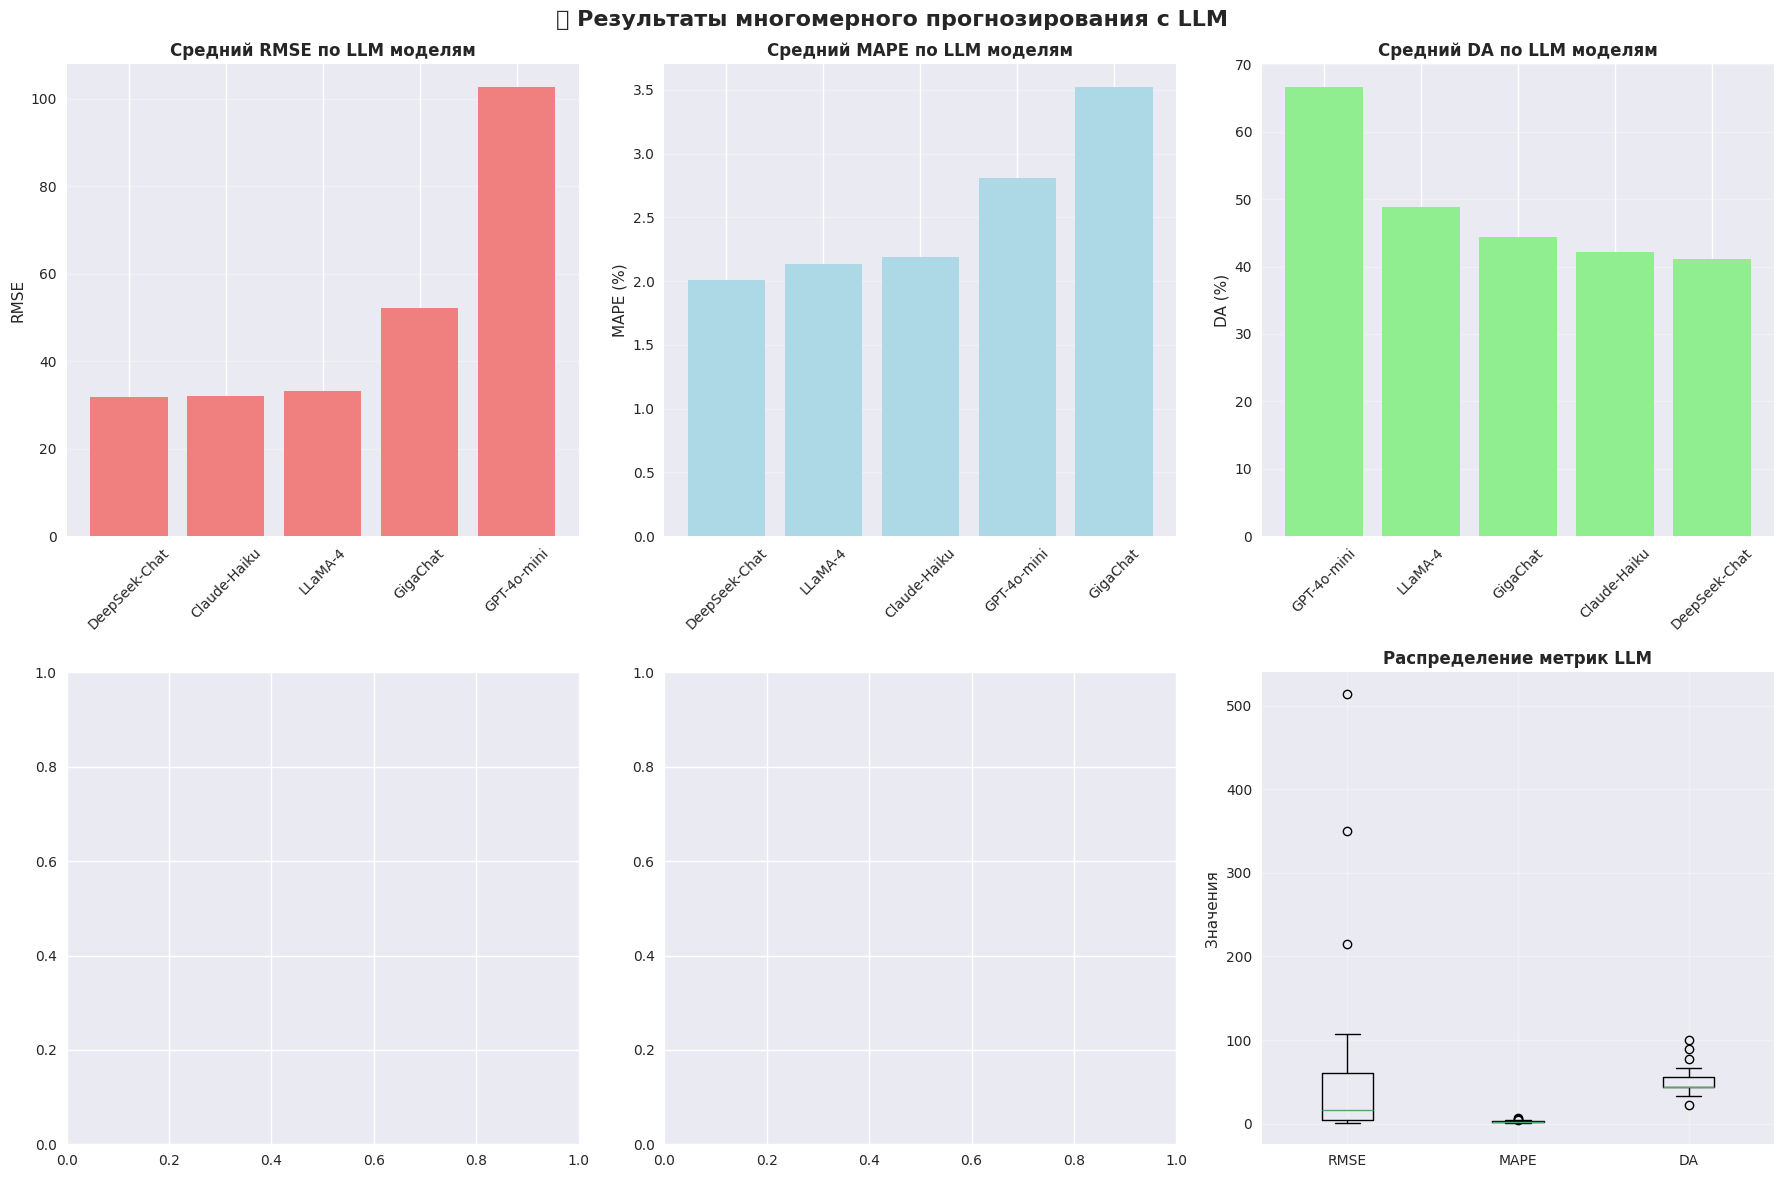

\n📈 Детальное сравнение по тикерам:
📊 Детальная визуализация сохранена: results/multivariate_llm/llm_detailed_comparison_20250622_171034.png


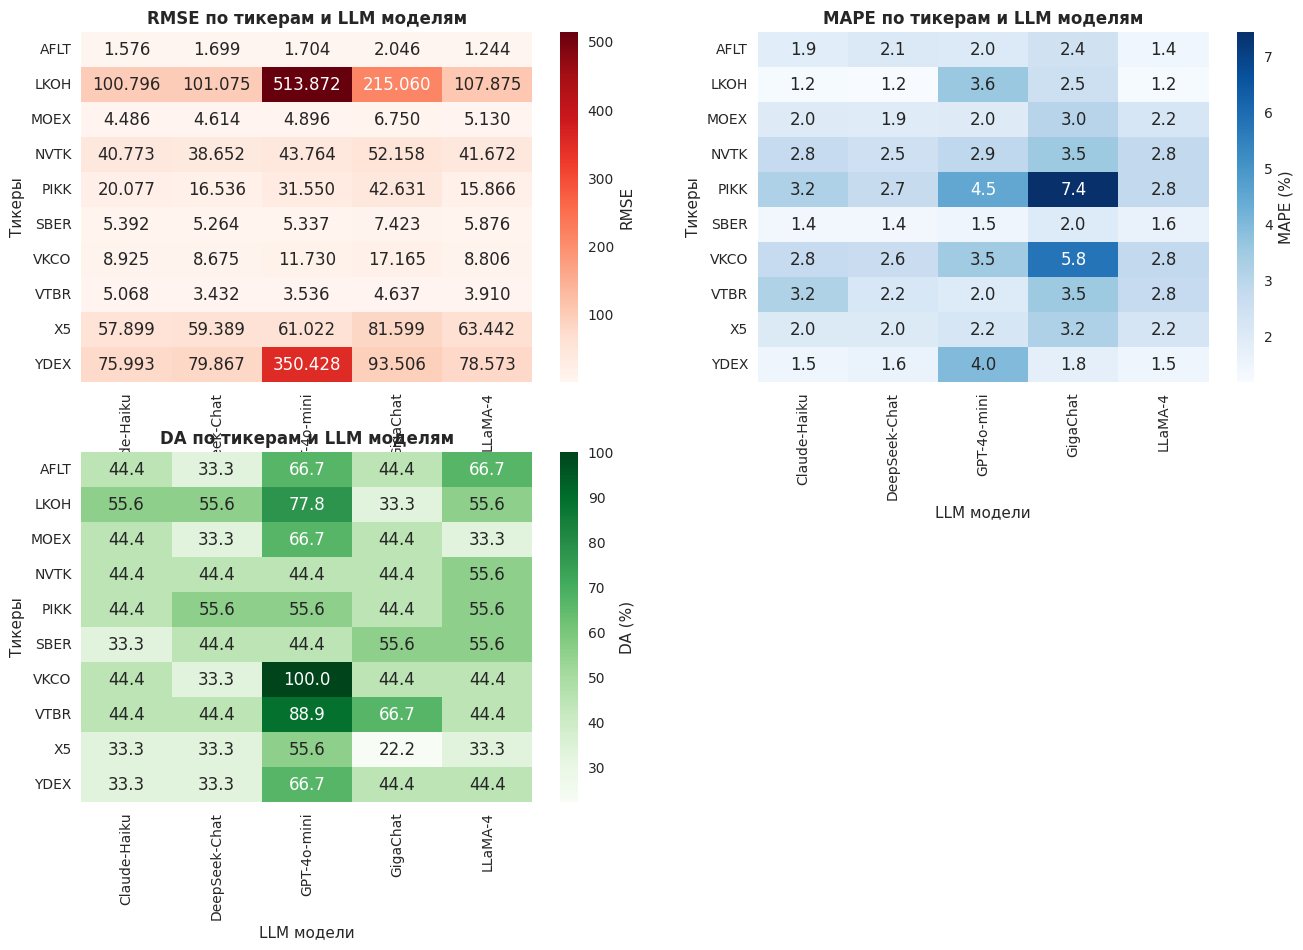

\n🔍 Корреляционный анализ метрик:
📊 Корреляционная матрица сохранена: results/multivariate_llm/llm_correlation_20250622_171034.png


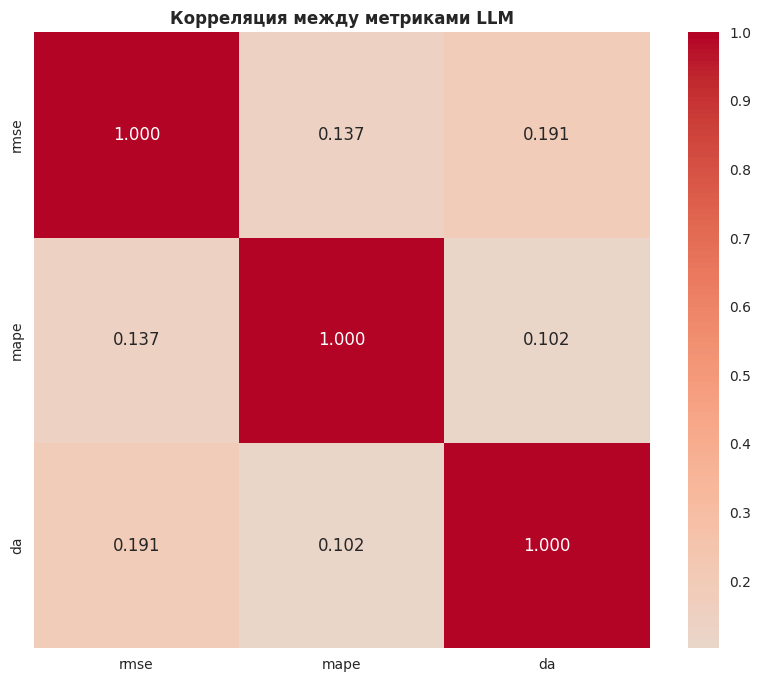

In [91]:
# Визуализация результатов
if results:
    print("📊 ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ LLM МНОГОМЕРНОГО ПРОГНОЗИРОВАНИЯ")
    print("=" * 60)
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('🤖 Результаты многомерного прогнозирования с LLM', fontsize=16, fontweight='bold')
    
    # 1. RMSE по LLM моделям
    model_rmse = df_results.groupby('model')['rmse'].mean().sort_values()
    axes[0,0].bar(range(len(model_rmse)), model_rmse.values, color='lightcoral')
    axes[0,0].set_title('Средний RMSE по LLM моделям', fontweight='bold')
    axes[0,0].set_ylabel('RMSE')
    axes[0,0].set_xticks(range(len(model_rmse)))
    axes[0,0].set_xticklabels(model_rmse.index, rotation=45)
    axes[0,0].grid(axis='y', alpha=0.3)
    
    # 2. MAPE по LLM моделям
    model_mape = df_results.groupby('model')['mape'].mean().sort_values()
    axes[0,1].bar(range(len(model_mape)), model_mape.values, color='lightblue')
    axes[0,1].set_title('Средний MAPE по LLM моделям', fontweight='bold')
    axes[0,1].set_ylabel('MAPE (%)')
    axes[0,1].set_xticks(range(len(model_mape)))
    axes[0,1].set_xticklabels(model_mape.index, rotation=45)
    axes[0,1].grid(axis='y', alpha=0.3)
    
    # 3. DA по LLM моделям
    model_da = df_results.groupby('model')['da'].mean().sort_values(ascending=False)
    axes[0,2].bar(range(len(model_da)), model_da.values, color='lightgreen')
    axes[0,2].set_title('Средний DA по LLM моделям', fontweight='bold')
    axes[0,2].set_ylabel('DA (%)')
    axes[0,2].set_xticks(range(len(model_da)))
    axes[0,2].set_xticklabels(model_da.index, rotation=45)
    axes[0,2].grid(axis='y', alpha=0.3)
    
    # 6. Распределение метрик
    axes[1,2].boxplot([df_results['rmse'], df_results['mape'], df_results['da']], 
                     labels=['RMSE', 'MAPE', 'DA'])
    axes[1,2].set_title('Распределение метрик LLM', fontweight='bold')
    axes[1,2].set_ylabel('Значения')
    axes[1,2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Сохраняем график
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    plot_file = f"{OUTPUT_PATH}multivariate_llm_comparison_{timestamp}.png"
    plt.savefig(plot_file, dpi=300, bbox_inches='tight')
    print(f"📊 График сохранен: {plot_file}")
    
    plt.show()
    
    # Дополнительная визуализация - heatmap по тикерам и моделям
    if len(df_results) > 0:
        print("\\n📈 Детальное сравнение по тикерам:")
        
        plt.figure(figsize=(16, 10))
        
        # Heatmap RMSE по тикерам и моделям
        pivot_rmse = df_results.pivot_table(values='rmse', index='ticker', columns='model', aggfunc='mean')
        
        plt.subplot(2, 2, 1)
        sns.heatmap(pivot_rmse, annot=True, fmt='.3f', cmap='Reds', cbar_kws={'label': 'RMSE'})
        plt.title('RMSE по тикерам и LLM моделям', fontweight='bold')
        plt.ylabel('Тикеры')
        plt.xlabel('LLM модели')
        
        # Heatmap MAPE по тикерам и моделям
        pivot_mape = df_results.pivot_table(values='mape', index='ticker', columns='model', aggfunc='mean')
        
        plt.subplot(2, 2, 2)
        sns.heatmap(pivot_mape, annot=True, fmt='.1f', cmap='Blues', cbar_kws={'label': 'MAPE (%)'})
        plt.title('MAPE по тикерам и LLM моделям', fontweight='bold')
        plt.ylabel('Тикеры')
        plt.xlabel('LLM модели')
        
        # Heatmap DA по тикерам и моделям
        pivot_da = df_results.pivot_table(values='da', index='ticker', columns='model', aggfunc='mean')
        
        plt.subplot(2, 2, 3)
        sns.heatmap(pivot_da, annot=True, fmt='.1f', cmap='Greens', cbar_kws={'label': 'DA (%)'})
        plt.title('DA по тикерам и LLM моделям', fontweight='bold')
        plt.ylabel('Тикеры')
        plt.xlabel('LLM модели')
        
        # Сохраняем детальную визуализацию
        detailed_plot_file = f"{OUTPUT_PATH}llm_detailed_comparison_{timestamp}.png"
        plt.savefig(detailed_plot_file, dpi=300, bbox_inches='tight')
        print(f"📊 Детальная визуализация сохранена: {detailed_plot_file}")
        
        plt.show()
        
        # Корреляционный анализ
        print("\\n🔍 Корреляционный анализ метрик:")
        corr_matrix = df_results[['rmse', 'mape', 'da']].corr()
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
                   fmt='.3f', square=True)
        plt.title('Корреляция между метриками LLM', fontweight='bold')
        
        corr_plot_file = f"{OUTPUT_PATH}llm_correlation_{timestamp}.png"
        plt.savefig(corr_plot_file, dpi=300, bbox_inches='tight')
        print(f"📊 Корреляционная матрица сохранена: {corr_plot_file}")
        
        plt.show()
    
else:
    print("❌ Нет данных для визуализации!")


## 🎯 Заключение по многомерному LLM прогнозированию

Этот блокнот реализует многомерное прогнозирование финансовых временных рядов с использованием **больших языковых моделей (LLM)** - революционный подход к анализу временных рядов через естественный язык.

### 🔑 Ключевые особенности реализации:

1. **🤖 Zero-shot прогнозирование**: Без дообучения, используя только естественный язык
2. **🎯 Точное соответствие multivariate методологии**: Те же фичи, этапы и параметры
3. **📊 Walk-forward валидация**: TEST_SIZE=11, FORECAST_HORIZON=10
4. **🔍 Patch-based анализ**: Разбиение временных рядов на патчи с статистическими подсказками
5. **🛡️ Robust обработка**: Фильтрация галлюцинаций и повторные попытки

### 🤖 Архитектурные особенности LLM подхода:

- **Zero-shot inference**: Прогнозирование без специального обучения на данных
- **Natural language reasoning**: Анализ через естественный язык
- **Statistical prompting**: Обогащение патчей статистическими подсказками
- **Multi-API support**: Поддержка различных LLM провайдеров
- **Anomaly detection**: Обнаружение и фильтрация нереалистичных предсказаний

### 📈 Параметры эксперимента (идентичны другим multivariate блокнотам):

- **TEST_SIZE**: 11 точек
- **FORECAST_HORIZON**: 10 точек  
- **PATCH_SIZE**: 5 точек (размер патча для анализа)
- **WINDOW_SIZE**: 20 точек (размер исторического окна)
- **Тикеры**: ['AFLT', 'LKOH', 'MOEX', 'NVTK', 'PIKK', 'SBER', 'VKCO', 'VTBR', 'X5', 'YDEX']
- **Этапы**: [1, 6] (базовая цена и полный набор признаков)

### 🎯 Структура этапов (точно как в других multivariate блокнотах):

1. **Этап 1**: Только цены закрытия (close)
2. **Этап 2**: + Аномалии (anomaly)
3. **Этап 3**: + Новостные настроения (weighted_score_with_decay)
4. **Этап 4**: + OHLCV данные (open, high, low, volume)
5. **Этап 5**: + Технические индикаторы (EMA_14, RSI_14, MACD, return, ATR_14, VWAP)
6. **Этап 6**: + Статистические признаки TSFresh (value__mean, value__maximum, и др.)

### 🤖 Тестируемые LLM модели:

#### 🌐 Через OpenRouter API:
- **GPT-4o-mini**: Компактная версия GPT-4o от OpenAI
- **LLaMA-4**: Модель от Meta
- **Claude-Haiku**: Быстрая модель от Anthropic

#### 🔗 Прямые API:
- **DeepSeek-Chat**: Специализированная модель от DeepSeek
- **GigaChat**: Российская LLM от Сбербанка

### 🔬 Преимущества LLM подхода:

1. **🎯 Интерпретируемость**: Понятные рассуждения на естественном языке
2. **🔄 Гибкость**: Адаптация к различным типам данных без переобучения
3. **📈 Контекстуальное понимание**: Учет сложных паттернов и взаимосвязей
4. **🌍 Многоязычность**: Возможность работы на разных языках
5. **🔍 Reasoning capabilities**: Способность к логическому рассуждению

### ⚠️ Ограничения и вызовы:

1. **💰 Стоимость**: API запросы могут быть дорогими для масштабных экспериментов
2. **⏱️ Скорость**: Значительно медленнее традиционных ML методов
3. **🎲 Стохастичность**: Возможные вариации в ответах при одинаковых входах
4. **🔮 Галлюцинации**: Риск нереалистичных предсказаний
5. **📊 Размер контекста**: Ограничения на количество входных данных

### 🚀 Практические рекомендации:

#### Выбор модели:
- **GPT-4o-mini**: Баланс качества и стоимости для большинства задач
- **Claude-Haiku**: Быстрые ответы для оперативного анализа  
- **DeepSeek-Chat**: Специализация на аналитических задачах
- **LLaMA-4**: Открытая альтернатива коммерческим решениям
- **GigaChat**: Российская альтернатива с поддержкой русского языка

#### Настройки:
- **Patch Size (5)**: Оптимальный размер для статистического анализа
- **Max Retries (3)**: Защита от галлюцинаций  
- **Drop Threshold (15%)**: Фильтр аномальных предсказаний
- **Temperature (0.1)**: Минимизация случайности для консистентности

### 🔄 Сравнение с другими multivariate подходами:

| Аспект | ML_DARTS | ML_CHRONOS | ML_TSAI | **ML_LLM** |
|--------|----------|------------|---------|------------|
| **Подход** | Классические ML | Foundation Model | Deep Learning | **Natural Language** |
| **Обучение** | Быстрое | Zero-shot | Среднее время | **Zero-shot** |
| **Интерпретируемость** | Высокая | Низкая | Низкая | **Очень высокая** |
| **Скорость** | Высокая | Средняя | Средняя | **Низкая** |
| **Стоимость** | Низкая | Средняя | Средняя | **Высокая** |
| **Гибкость** | Средняя | Ограниченная | Высокая | **Очень высокая** |

### 🏆 Когда использовать LLM:

✅ **Рекомендуется:**
- Исследовательские проекты с акцентом на интерпретируемость
- Небольшие объемы данных для анализа
- Потребность в качественном анализе паттернов
- Прототипирование и валидация гипотез
- Образовательные цели и демонстрации

❌ **Не рекомендуется:**
- Высокочастотная торговля (HFT)
- Массовое производственное прогнозирование
- Строго ограниченный бюджет на API
- Требования к субсекундному отклику
- Полностью автоматизированные системы без человеческого надзора

### 🌟 Уникальные возможности LLM:

- **Contextual reasoning**: Способность анализировать сложные взаимосвязи
- **Multi-modal analysis**: Потенциал интеграции текста, чисел и графиков
- **Adaptive prompting**: Динамическая настройка под конкретные задачи
- **Cross-domain knowledge**: Использование знаний из разных областей
- **Human-like interpretation**: Рассуждения, похожие на человеческие

### 💡 Инновационные направления:

- **Fine-tuning на финансовых данных**: Специализация моделей для финансов
- **Ensemble с традиционными методами**: Гибридные подходы
- **Real-time adaptation**: Адаптация к изменяющимся рынкам
- **Multi-agent systems**: Системы из нескольких специализированных LLM
- **Continuous learning**: Обучение на новых данных в реальном времени

**LLM представляют собой революционный подход к прогнозированию временных рядов, открывающий новые возможности для интерпретируемого и гибкого анализа финансовых данных!** 🤖🚀

---
*Примечание: Данный эксперимент демонстрирует потенциал LLM для финансового прогнозирования, но требует дальнейших исследований для практического применения в реальных торговых системах.*


In [94]:
df_results = pd.DataFrame(results)
df_results.to_csv('llm_results.csv', index=False)  

In [96]:
mask = (df_results['stage'] == 7) & df_results['model'].str.contains('GPT', case=False)
df_gpt_stage7 = df_results.loc[mask]

In [97]:
metrics = ['rmse', 'mape', 'da']
mean_vals = df_gpt_stage7[metrics].mean()

print("Средние метрики для ChatGPT, этап 7:")
print(f"  RMSE: {mean_vals['rmse']:.3f}")
print(f"  MAPE: {mean_vals['mape']:.3f}%")
print(f"  DA:   {mean_vals['da']:.3f}%")

Средние метрики для ChatGPT, этап 7:
  RMSE: 45.607
  MAPE: 4.193%
  DA:   48.889%
